In [4]:
#loading all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder


In [5]:
# Load train dataset
df = pd.read_csv('/content/train.csv')
# Load features dataset and join it with train data
features_df = pd.read_csv('/content/features.csv')
df = pd.merge(df, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])
# Load store dataset and join with above data
stores_df = pd.read_csv('/content/stores.csv')
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])
df.shape
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,FALSE,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,TRUE,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,FALSE,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,FALSE,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,FALSE,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [6]:
# Let's explore variables, their data types, and total non-null values
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 70562 entries, 0 to 70561
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         70562 non-null  int64  
 1   Dept          70562 non-null  int64  
 2   Date          70562 non-null  object 
 3   Weekly_Sales  70562 non-null  float64
 4   IsHoliday     70562 non-null  object 
 5   Temperature   70562 non-null  float64
 6   Fuel_Price    70562 non-null  float64
 7   MarkDown1     25234 non-null  float64
 8   MarkDown2     20168 non-null  float64
 9   MarkDown3     23702 non-null  float64
 10  MarkDown4     24889 non-null  float64
 11  MarkDown5     25234 non-null  float64
 12  CPI           70562 non-null  float64
 13  Unemployment  70562 non-null  float64
 14  Type          70562 non-null  object 
 15  Size          70562 non-null  int64  
dtypes: float64(10), int64(3), object(3)
memory usage: 9.2+ MB


In [7]:
# summary statistics of the dataset
df[['Weekly_Sales', 'Temperature', 'CPI', 'Size']].describe()


,Weekly_Sales,Temperature,CPI,Size
count,70562.000000,70562.000000,70562.000000,70562.000000
mean,17544.341381,63.945482,200.967795,133568.325161
std,25757.966720,17.994359,31.155787,71868.085398
min,-1098.000000,-2.060000,126.064000,34875.000000
25%,2342.882500,51.180000,196.951558,37392.000000
50%,7736.345000,66.270000,213.667086,151315.000000
75%,21096.477500,79.510000,219.237049,202505.000000
max,385051.040000,93.340000,227.036936,205863.000000


In [8]:
print('Min Date in Data is - {}'.format(df['Date'].min()))
print('Max Date in Data is - {}'.format(df['Date'].max()))


Min Date in Data is - 2010-02-05
Max Date in Data is - 2012-10-26


  Type  Store
0    A      5
1    B      3


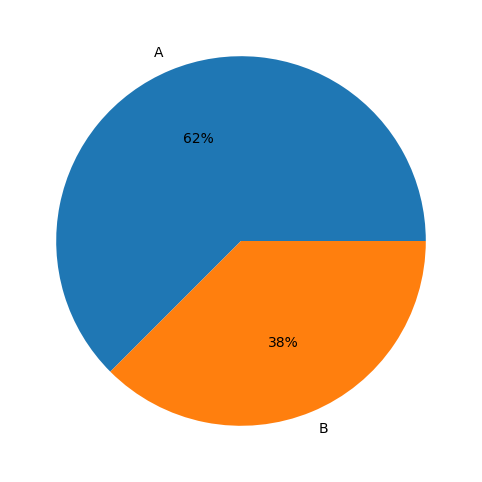

In [9]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'], autopct = '%.0f%%')
plt.show()


<Axes: xlabel='Type', ylabel='Size'>

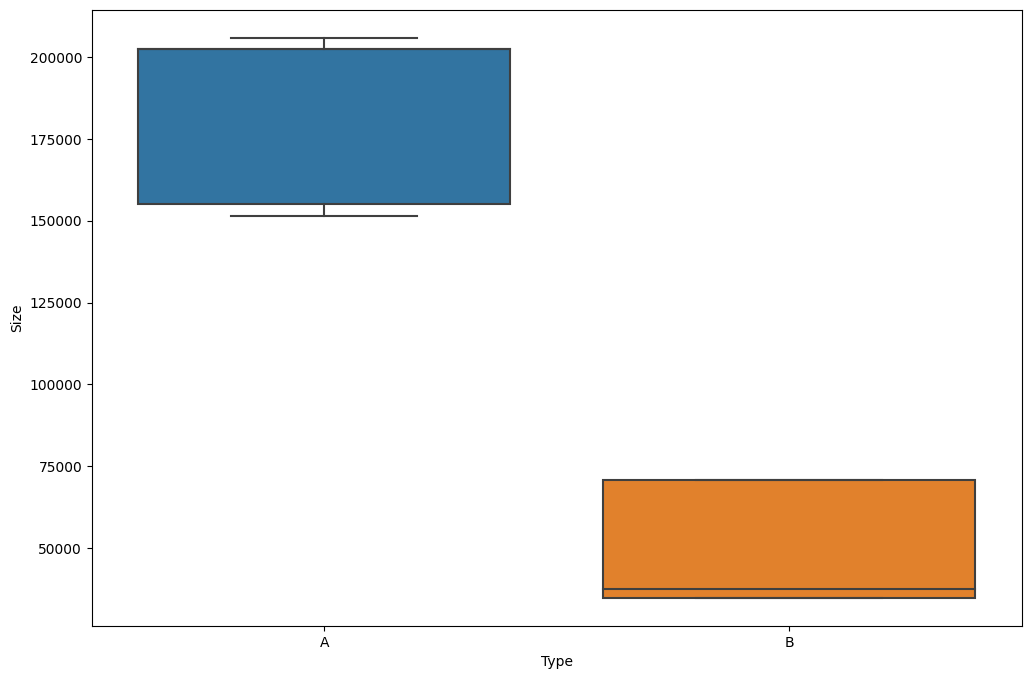

In [10]:
# size distribution of stores for each store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)


<Axes: xlabel='Type', ylabel='Weekly_Sales'>

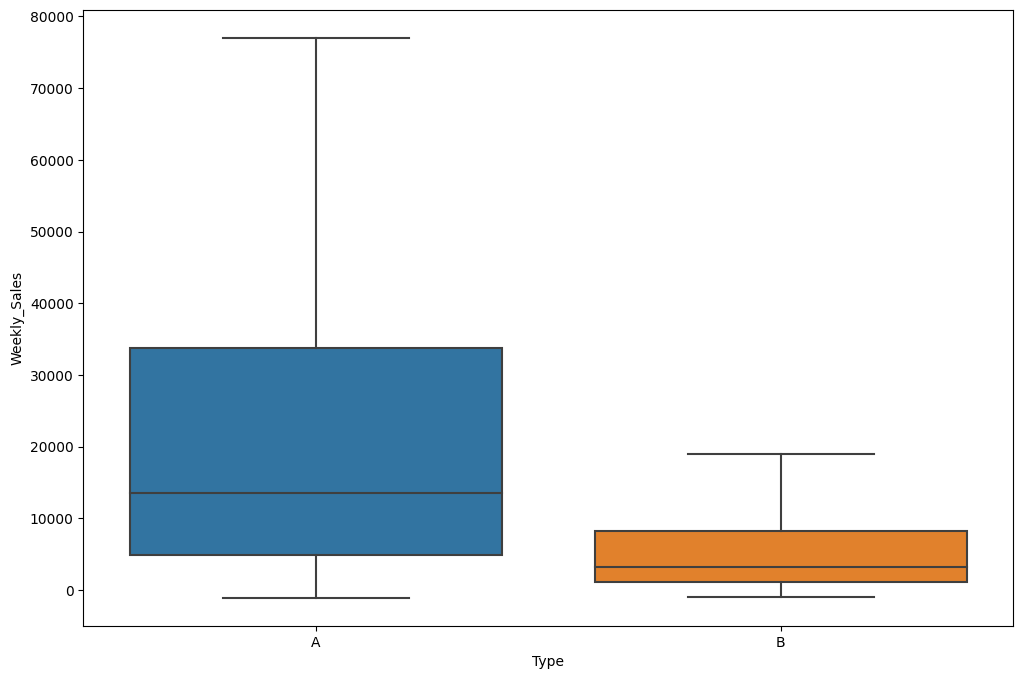

In [11]:
# Distribution of weekly sales based on store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: xlabel='Type', ylabel='Weekly_Sales'>

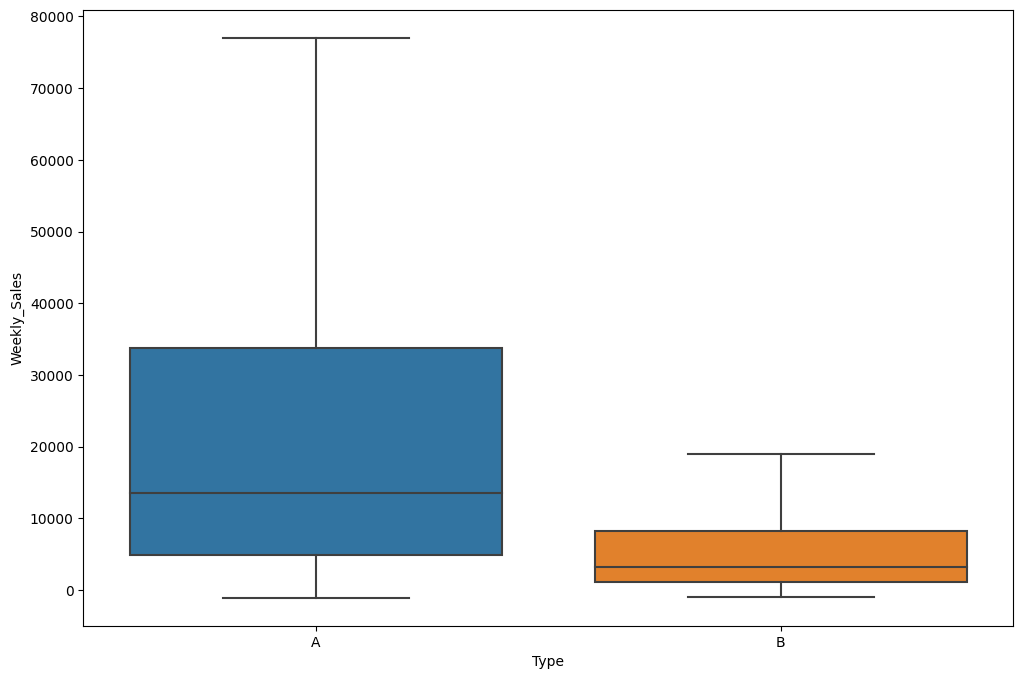

In [12]:
# Distribution of weekly sales based on store type
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: >

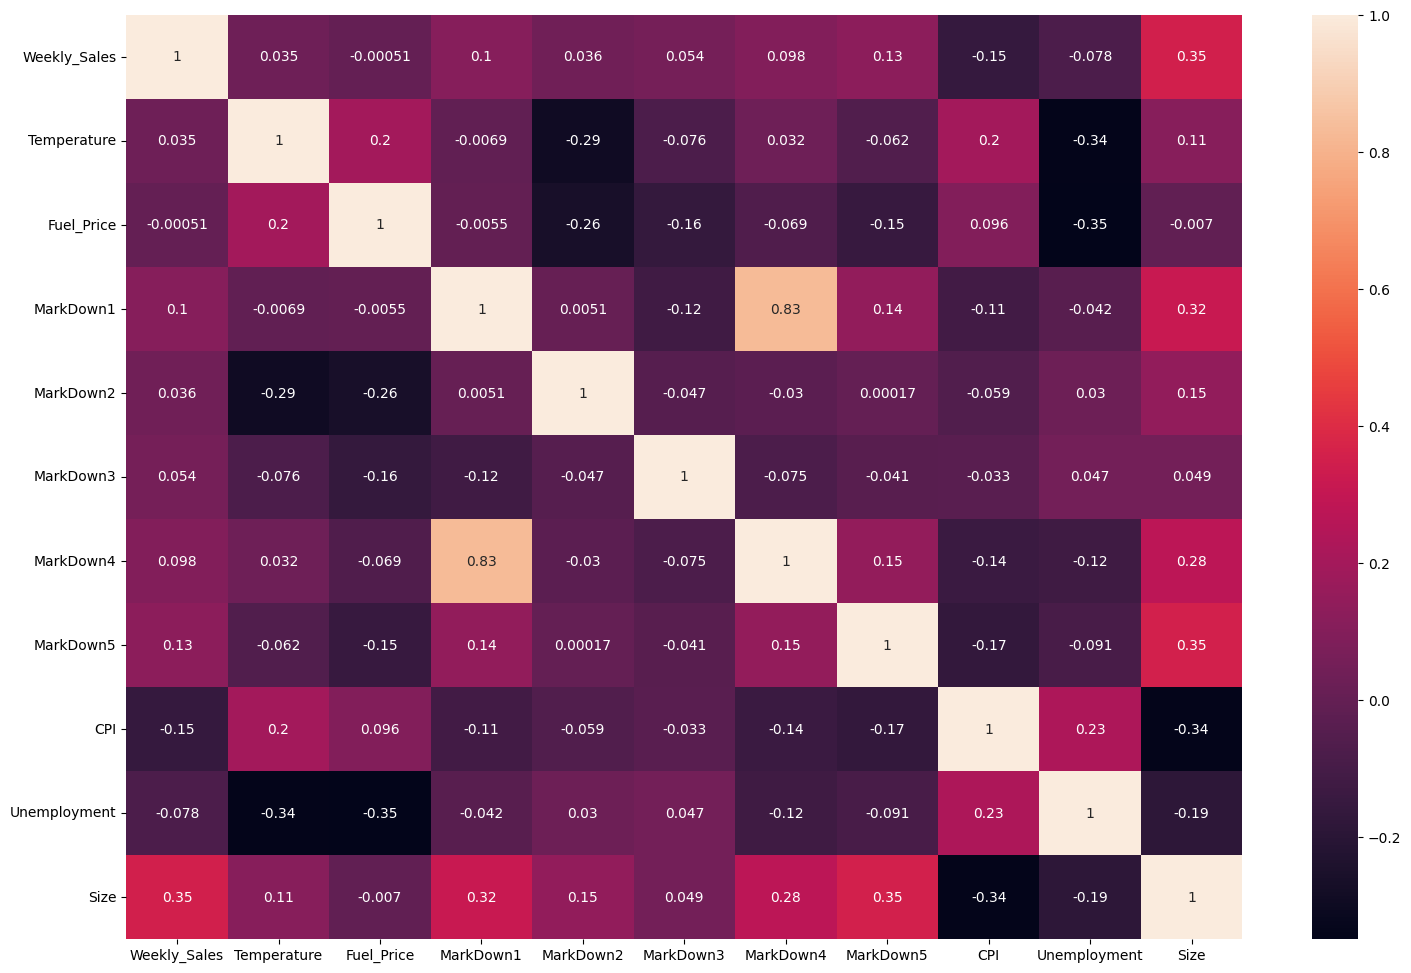

In [13]:
feature_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size']
plt.figure(figsize = (18,12))
sns.heatmap(df[feature_cols].corr(), annot = True)


In [14]:
# Impute NULL values
df['MarkDown1'] = df['MarkDown1'].fillna(0)
df['MarkDown2'] = df['MarkDown2'].fillna(0)
df['MarkDown3'] = df['MarkDown3'].fillna(0)
df['MarkDown4'] = df['MarkDown4'].fillna(0)
df['MarkDown5'] = df['MarkDown5'].fillna(0)

# create year, month, and date
df['Date'] = pd.to_datetime(df['Date'])
df['month_date'] = df['Date'].apply(lambda i : i.month)
df['day_date'] = df['Date'].apply(lambda i : i.day)
df['year_date'] = df['Date'].apply(lambda i : i.year)

# one hot encoding
cols_to_encode = ['Type', 'IsHoliday']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)

# Standard Scaler
standard_scaler = StandardScaler()
feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
transformed_features = standard_scaler.fit_transform(df[feature_cols])

df[feature_cols] = transformed_features

# split data into train and test
feature_cols  = df.columns.tolist()
feature_cols = [i for i in feature_cols if i not in ['Date', 'Weekly_Sales']]
x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['Weekly_Sales'], test_size = 0.2, random_state = 1234)


In [15]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors = 10, n_jobs = 4)
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {knn_regressor.score(x_test, y_test)}')


MAE is - 9402.615855098136
RMSE is - 15729.973240459905
Accuracy Score is - 0.6317244512905416


<Axes: xlabel='Weekly_Sales'>

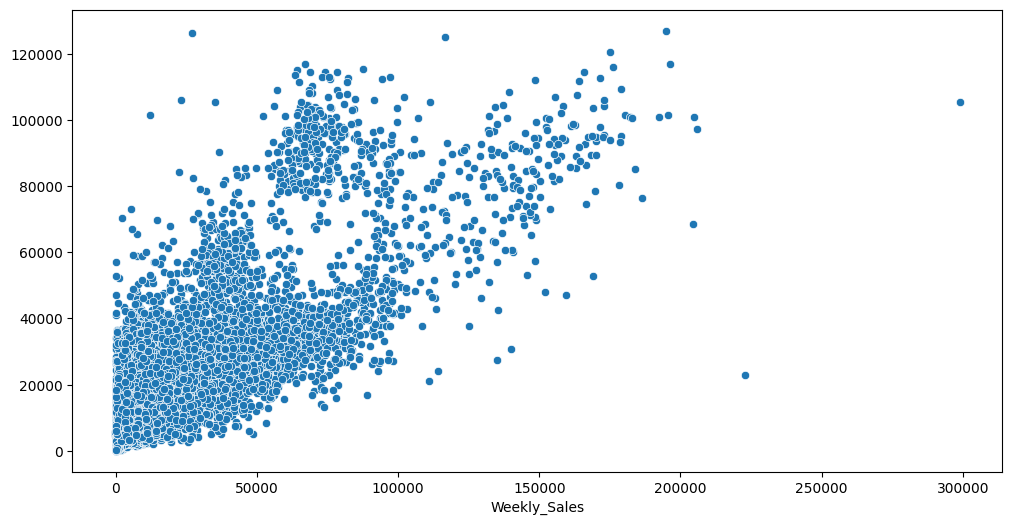

In [16]:
# scatter plot between observed and predicted values of weekly sales from KNN regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)


In [17]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor = DecisionTreeRegressor(random_state = 1234)
decision_tree_regressor.fit(x_train, y_train)
y_pred = decision_tree_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {decision_tree_regressor.score(x_test, y_test)}')


MAE is - 2004.7700680223907
RMSE is - 4945.386250780039
Accuracy Score is - 0.9635986616206169


In [ ]:
rf_regressor = RandomForestRegressor(n_estimators = 400, max_depth = 15, random_state = 1234, n_jobs = 5)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {rf_regressor.score(x_test, y_test)}')


In [ ]:
xgb_regressor = XGBRegressor(objective = 'reg:linear', n_estimators = 500, max_depth = 6, nthread = 4, learning_rate = 0.5, random_state = 1234)
xgb_regressor.fit(x_train, y_train)
y_pred = xgb_regressor.predict(x_test)

print(f'MAE is - {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is - {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Accuracy Score is - {xgb_regressor.score(x_test, y_test)}')


In [ ]:
# scatter plot between observed and predicted values of weekly sales from XGBoost regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)
